# Active Session 1: Introduction to CNN

#Important Note

Lecture notes and notebooks must not be copied and/or distributed without the express permission of ITS.





#1. Problem Definition: Probing into the Data

In this dataset, we will explore a medical case study: (malignant) melanoma, which is a type of skin cancer that develops from the pigment-producing cells known as melanocytes. 

Identifying melanoma at an early stage is very crucial; as  the early detection can vastly increase your chances for cure up to 99%. The survival rate drops from to 66% if the disease reaches the lymph nodes and
27% if it spreads to distant organs [[1]](https://www.skincancer.org/skin-cancer-information/melanoma/melanoma-warning-signs-and-images/). 

The problem has serious consequences hence has been addressed by the community in different ways, mainly revolving around alternative CNN architectures and pre-trained and/or attention based models. We will use a relatively smaller database as an exercise to explore the CNN implementation in TF and how to call pre-trained models for the task later on. 




# 2. Preparing the enviroment

Import the Python libraries that we will need to (i) load the data, (ii) analyze it, (iii) create our model, (iv) process the results.

In [2]:
!pip install ipython-autotime
%load_ext autotime

time: 0 ns (started: 2023-05-25 19:16:39 +02:00)


In [8]:
#Importing the necessary libraries
import math
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from glob import glob
from PIL import Image
import cv2
import zipfile

time: 0 ns (started: 2023-05-25 19:22:32 +02:00)


In [4]:
# Data Preparation and Scoring
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LogNorm
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools
from tqdm import tqdm
from tensorflow.keras.utils import plot_model
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from keras.preprocessing.image import ImageDataGenerator

time: 4.73 s (started: 2023-05-25 19:16:44 +02:00)


In [5]:
# ML Algorithms to be used
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Input, Lambda, Flatten

from keras.utils.np_utils import to_categorical

tf.__version__


'2.10.0'

time: 16 ms (started: 2023-05-25 19:16:50 +02:00)


In [6]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0
time: 1.39 s (started: 2023-05-25 19:16:54 +02:00)


In [7]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # If there are GPUs available, print a message and enable memory growth
  print("GPU is available")
  for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(tf.config.list_physical_devices('GPU'))
else:
  print("GPU is not available")

GPU is available
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
time: 0 ns (started: 2023-05-25 19:18:02 +02:00)


# 3. Pre-processing


## Loading the Data

We need to upload the dataset to Colab enviroment. The original  dataset is coming from the ISIC (International Skin Image Collaboration) Archive. It includes 1800 pictures of benign moles and 1497 pictures of malignant classified moles. The database have all been resized to low resolution (224x224x3) RGB. 

The data can be either loaded manually or can be read from google drive. We will follow the second route.

In [6]:
# Loading the data

#Local drive:
#from google.colab import files
#uploaded = files.upload()


time: 231 µs (started: 2023-05-17 16:19:13 +00:00)


In [7]:
# # Loading the data
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

time: 22.5 s (started: 2023-05-17 16:19:13 +00:00)


In [9]:
# # Note that you need to insert your own id for your file in the cloud.
# CNN_data = drive.CreateFile({'id':'1fzaWN9j6FGIvkdaj6qJIKHZJRS9gP-ty'}) 
# CNN_data.GetContentFile('CNN.zip')

def extract_zip_file():
    cwd = os.getcwd()
    DATA_PATH = os.path.join(cwd, '..', 'data')
    RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw')
    zip_path = os.path.join(RAW_DATA_PATH, "CNN.zip")

    # Extract the zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(RAW_DATA_PATH)
    print("Zip file extracted.")

extract_zip_file()


Zip file extracted.
time: 7.41 s (started: 2023-05-25 19:25:30 +02:00)


In [12]:
# The file is downloaded on the cloud workspace:
# !ls
cwd = os.getcwd()
DATA_PATH = os.path.join(cwd, '..', 'data')
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw')
print(os.listdir(RAW_DATA_PATH))

['.gitkeep', 'CNN.zip', 'data', 'test', 'train']
time: 0 ns (started: 2023-05-25 19:28:25 +02:00)


In [10]:
# #Unzipping the flie:
# !unzip -qq CNN.zip
# !ls

CNN.zip  data  sample_data  test  train
time: 6.14 s (started: 2023-05-17 16:19:45 +00:00)


## Train-Test Split

OUr task is binary classification, which is supervised learning. Therefore, we need to create a train/test split. In the original dataset, this was already done to present the same split to those who would dive into the challange -- just be fair. So our task here is to take these folders, create objects and assign labels based on the folder they belong to. 

Note that we do not have any other features. A more recent, higher resolution database also provides additional information on the samples. You can eplore the newer challange from here:

https://www.kaggle.com/c/siim-isic-melanoma-classification

We will look into a bit older but smaller dataset, particularly to discuss the role of transfer learning in the following lecture. 

Now returning back to our problem, lets create our training-test data, the function image_reader(directory,size=224) reads all the images from a specified directory, converts them to RGB format, resizes them to a specified size, normalizes them (so that all values are between 0 and 1), and finally stores them in a list.

In [13]:
# Creating a function to read the images from the files:
def image_reader(directory,size=224):
    images = []
    # We are going to use Python Imaging Library for image management.
    #for more, you can check:
    #https://pillow.readthedocs.io/en/stable/reference/Image.html#
    #https://pillow.readthedocs.io/en/stable/reference/Image.html?highlight=convert#PIL.Image.Image.convert
    readed = lambda image_name: np.asarray(Image.open(image_name).convert("RGB"))
    # We will create a loop for reading images in a given directory and resize it if needed.
    #---------------------------------------------------------------------------
    # Just to have a cool window in the progress, we will use tqdm.
    # "tqdm derives from the Arabic word taqaddum (تقدّم) which can mean “progress,” 
    # and is an abbreviation for “I love you so much” in Spanish (te quiero demasiado). 
    # Instantly make your loops show a smart progress meter - just wrap any iterable with 
    # tqdm(iterable), and you're done!".
    #---------------------------------------------------------------------------
    for i_image in tqdm(os.listdir(directory)):
        PATH = os.path.join(directory,i_image)
        img_loop = readed(PATH)
        # Resizing image if needed:
        img_loop = cv2.resize(img_loop, (size,size))
        # Normalizing the colors
        #-----------------------------------------------------------------------
        # RGB (Red, Green, Blue) are 8 bit each and the range for each individual 
        # colour is 0-255 (2^8 = 256). By dividing by 255, the 0-255 range is converted to
        # a range between 0.0-1.0.
        #-----------------------------------------------------------------------
        images.append(np.array(img_loop)/255.)
    return images

time: 0 ns (started: 2023-05-25 19:45:16 +02:00)


In [14]:
#lets remember the files:
# !ls

print(os.listdir(RAW_DATA_PATH))

['.gitkeep', 'CNN.zip', 'data', 'test', 'train']
time: 0 ns (started: 2023-05-25 19:47:34 +02:00)


In [17]:
# Reading the images
#train data:
benign_train = np.array(image_reader(os.path.join(RAW_DATA_PATH, 'data', 'train', 'benign')))
malignant_train = np.array(image_reader(os.path.join(RAW_DATA_PATH, 'data', 'train', 'malignant')))
#test data:
benign_test = np.array(image_reader(os.path.join(RAW_DATA_PATH, 'data', 'test', 'benign')))
malignant_test = np.array(image_reader(os.path.join(RAW_DATA_PATH, 'data', 'test', 'malignant')))

100%|██████████| 300/300 [00:01<00:00, 256.35it/s]


time: 20.8 s (started: 2023-05-25 19:51:43 +02:00)


In [13]:
# # Reading the images
# #train data:
# benign_train = np.array(image_reader('./data/train/benign'))
# malignant_train = np.array(image_reader('./data/train/malignant'))
# #test data:
# benign_test = np.array(image_reader('./data/test/benign'))
# malignant_test = np.array(image_reader('./data/test/malignant'))

100%|██████████| 300/300 [00:01<00:00, 227.32it/s]


time: 19 s (started: 2023-05-17 16:19:51 +00:00)


Note that the ratio of benign/malignant is relatively balanced. This is an important information as it affects our evaluation matrices (you may check the classification lecture of DDE1 for further information). 

Now we have read the images and converted them into numpy arrays. The next step is to create labels. This could have been done with the `image_reader` as well. 

In [18]:
print(np.shape(benign_train), np.shape(benign_test))
print(np.shape(malignant_train), np.shape(malignant_test))

(1440, 224, 224, 3) (360, 224, 224, 3)
(1197, 224, 224, 3) (300, 224, 224, 3)
time: 16 ms (started: 2023-05-25 19:54:39 +02:00)


In [19]:
# Creating individual labels:
#----------------------------
y_benign_train = np.zeros(benign_train.shape[0])
y_malignant_train = np.ones(malignant_train.shape[0])
y_benign_test = np.zeros(benign_test.shape[0])
y_malignant_test = np.ones(malignant_test.shape[0])
#
# Merging the arrays: 
#----------------------------
#images:
X_train = np.concatenate((benign_train, malignant_train), axis = 0)
#labels:
y_train = np.concatenate((y_benign_train, y_malignant_train), axis = 0)
#images:
X_test = np.concatenate((benign_test, malignant_test), axis = 0)
#labels:
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

time: 23.3 s (started: 2023-05-25 19:55:50 +02:00)


In [20]:
del benign_train, malignant_train, benign_test, malignant_test
del y_benign_train, y_malignant_train, y_benign_test, y_malignant_test

time: 297 ms (started: 2023-05-25 19:58:58 +02:00)


In [21]:
print(np.shape(X_train), np.shape(y_train))
print(np.shape(X_test), np.shape(y_test))

(2637, 224, 224, 3) (2637,)
(660, 224, 224, 3) (660,)
time: 0 ns (started: 2023-05-25 19:59:09 +02:00)


In [22]:
# Since the data is perfectly ordered in label, we need to suffle it:
#
# first we will create a list of random numbers with the same size of our arrays.
# then reorder them accordingly.
s = np.arange(X_train.shape[0])
print(np.shape(s))
np.random.shuffle(s) 
X_train = X_train[s]
y_train = y_train[s]
# The same is done for the test data:
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

(2637,)
time: 28.1 s (started: 2023-05-25 20:01:00 +02:00)


## Visualization of the samples
We do not have many options for EDA. Lets see how the image samples look like. 

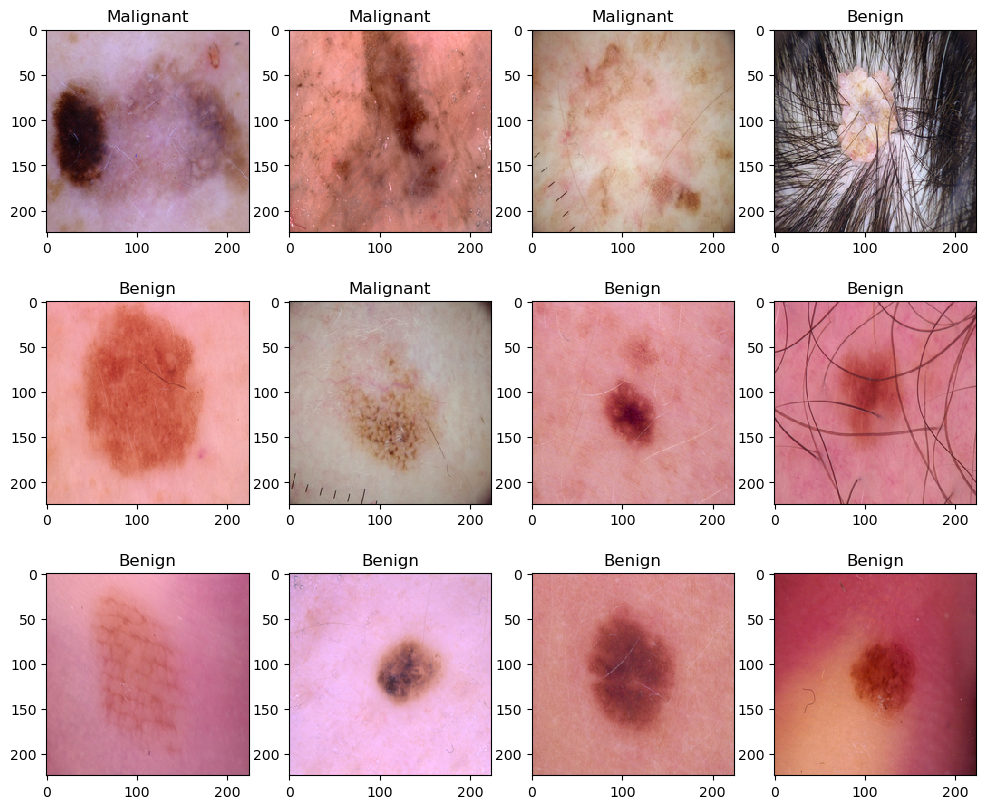

time: 2.78 s (started: 2023-05-25 20:03:57 +02:00)


In [23]:
#Creating a figure including sub-figures:
fig=plt.figure(figsize=(12, 10))
for i in range(1, 12 +1):
    ax = fig.add_subplot(3, 4, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

## Creating catagorical labels
We will here first create a validation dataset for NN training monitoring and then covert our labels into catagorical values with one hot encoding.

https://medium.com/@michaeldelsole/what-is-one-hot-encoding-and-how-to-do-it-f0ae272f1179

In [19]:
# One hot encoding:
#y_train = to_categorical(y_train, num_classes= 2)
#y_test = to_categorical(y_test, num_classes= 2)

time: 353 µs (started: 2023-05-17 16:20:26 +00:00)


# Building our own CNN

The data is ready to be processed. We will use TensorFlow to build our own architecture for the image classification task. This is still a NN and we will apply a similar workflow to create and train the model. 

The process starts with the creation of graph representation. 



In [24]:
def build_model_CNN():
  # input array shape for the network:
  input_shape = X_train.shape[1],X_train.shape[2],X_train.shape[3]
  #Here we will use Sequential API like we did in MLP
  model = models.Sequential([
  # Now we will introduce the layers. We will start with the convolution layer:
  #https://keras.io/api/layers/convolution_layers/
  #https://keras.io/api/layers/convolution_layers/convolution2d/
  Conv2D(64,(3,3),(1,1),padding='same',activation="relu",kernel_initializer="he_uniform",input_shape=input_shape),

  # Conv2D(64,(3,3),(1,1),padding='same',...) is calling the function to create a 2D convolutional layer.
  # The first argument 64 is specifying that we want this layer to learn 64 filters. Filters are essentially patterns that the layer will learn to recognize from the input data.
  # The second argument (3,3) is specifying the size of these filters as being 3 pixels by 3 pixels. So each filter will consider a small square of 3x3 pixels from the input data at a time.
  # The third argument (1,1) indicates the stride of the convolution, which is the amount by which the filter moves over the input image. Here, it moves one pixel at a time, both horizontally and vertically.
  # The padding='same' argument means that the input data is padded with zeros around the edges, so the spatial dimensions (i.e., the width and height) of the output image are the same as those of the input image. This is useful when you want to maintain the spatial dimensions of the image after convolution.
  # The activation="relu" argument specifies the activation function for the neurons in this layer. The Rectified Linear Unit (ReLU) function is a commonly used activation function that outputs the input directly if it's positive, else it will output zero.
  # kernel_initializer="he_uniform" specifies the method to be used for initializing the weights in this layer. In this case, the "He Uniform" method is used, which is an efficient way of initializing weights such that it maintains the variance of the inputs across each layer.
  # Finally, input_shape=input_shape specifies the shape of the input data that this layer will be receiving. It's generally only needed for the first layer in a model, and it's equivalent to specifying the number of channels in the input image and its dimensions (height, width). In this case, the input shape is determined by the shape of your training data.  

  # filter of size 3 by 3 applied to 64 images and there is no stride,
  # it is moving one by one.
  #Adding the pooling layer:
  #https://keras.io/api/layers/pooling_layers/
  #https://keras.io/api/layers/pooling_layers/max_pooling2d/
  MaxPooling2D((2,2),padding='same'),
  BatchNormalization(),
  Dropout(0.2),
  #
  #Second conv. layer:
  Conv2D(64,(3,3),(1,1),padding='same',activation="relu",kernel_initializer="he_uniform"),
  MaxPooling2D((2,2),padding='same'),
  BatchNormalization(),
  Dropout(0.2),
  #
  #Third conv. layer:
  Conv2D(64,(3,3),(1,1),padding='same',activation="relu",kernel_initializer="he_uniform"),
  MaxPooling2D((2,2),padding='same'),
  BatchNormalization(),
  Dropout(0.2),
  #
  #Connecting to dense layer:
  Flatten(),
  # The Flatten layer reshapes the tensor to have a shape that is equal to the number of elements contained in the tensor. 
  # In other words, it collapses the spatial dimensions of the input into the channel dimension. This is done because fully connected layers (like the dense layer in your model) expect 1D vectors as input.
  # Here, the Flatten layer is being used as a bridge between the convolutional layers and the dense layers. The convolutional layers learn the local patterns in the initial images, then the Flatten layer unrolls these 2D feature maps into 1D, and finally the dense layers learn global patterns in these 1D features.
  # In summary, the purpose of flattening is to convert the 2D feature maps learned by the convolutional layers into a format that can be processed by the dense layers, which will then perform the final classification. 
  #Ready to link MLP
  Dense(128,activation="relu",kernel_initializer="he_uniform"),
  BatchNormalization(),
  Dropout(0.3),
  Dense(1,activation="sigmoid")
  ])  
  model.compile(optimizer='Adam',loss = "binary_crossentropy", metrics=["accuracy"]) 
  return model


time: 0 ns (started: 2023-05-25 20:57:22 +02:00)


In [25]:
#Looking at the graph:
build_model_CNN().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0

## Model training

Our model is ready as a graph object. Now we are ready to train it with our dataset. As usual, we will create a checkpoint to save better results and use early stopping to limit the training period, as well as over fitting.

In [26]:
#We will first create the object to feed fit() method:
myCheckpoint= keras.callbacks.ModelCheckpoint("my_best_model.h5", save_best_only=True)

time: 16 ms (started: 2023-05-25 21:09:02 +02:00)


In [27]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
myEarly_stopping = keras.callbacks.EarlyStopping(patience=25,restore_best_weights=True)

time: 0 ns (started: 2023-05-25 21:09:04 +02:00)


In [28]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 100
batch_size = 32

time: 0 ns (started: 2023-05-25 21:09:06 +02:00)


In [29]:
# Model Training:
#-----------------------------------------------------------------------------
#Building the Keras models:
model_CNN = build_model_CNN()

#Training step: Trains the model in silent mode (verbose = 0)
history= model_CNN.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.2, 
                                callbacks=[myCheckpoint,myEarly_stopping])#, verbose=0)
#Calling back the best model:
model_best= keras.models.load_model("my_best_model.h5")


Epoch 1/100
66/66 [==============================] - 48s 456ms/step - loss: 0.5563 - accuracy: 0.7591 - val_loss: 1.3503 - val_accuracy: 0.5473
Epoch 2/100
66/66 [==============================] - 9s 138ms/step - loss: 0.4339 - accuracy: 0.7937 - val_loss: 1.3247 - val_accuracy: 0.5587
Epoch 3/100
66/66 [==============================] - 13s 192ms/step - loss: 0.4035 - accuracy: 0.8009 - val_loss: 0.4811 - val_accuracy: 0.7405
Epoch 4/100
66/66 [==============================] - 16s 243ms/step - loss: 0.3741 - accuracy: 0.8203 - val_loss: 0.5094 - val_accuracy: 0.7083
Epoch 5/100
66/66 [==============================] - 16s 251ms/step - loss: 0.3479 - accuracy: 0.8303 - val_loss: 0.4537 - val_accuracy: 0.7481
Epoch 6/100
66/66 [==============================] - 19s 284ms/step - loss: 0.3209 - accuracy: 0.8497 - val_loss: 0.6001 - val_accuracy: 0.6894
Epoch 7/100
66/66 [==============================] - 19s 284ms/step - loss: 0.2954 - accuracy: 0.8658 - val_loss: 0.4246 - val_accuracy: 

In [26]:
#Lets look into the history recorded:
hist = pd.DataFrame(history.history)
hist.sample(3)

,loss,accuracy,val_loss,val_accuracy
31,0.034646,0.990991,0.689184,0.842803
16,0.091369,0.965386,0.418942,0.840909
17,0.081988,0.976292,0.382998,0.846591


time: 51.5 ms (started: 2023-05-17 15:13:57 +00:00)


In [27]:
#Adding epoch column:
hist['epoch'] = history.epoch
# As you can see, we have the losses as well as mae for both training and CV data:
hist.sample(3)

,loss,accuracy,val_loss,val_accuracy,epoch
17,0.081988,0.976292,0.382998,0.846591,17
14,0.124511,0.956852,0.444759,0.799242,14
4,0.341111,0.842579,0.456865,0.763258,4


time: 15.8 ms (started: 2023-05-17 15:13:57 +00:00)


In [28]:
# Defining our function to see the evolution of error:
def plot_learning_curves(history):
  #We will omit the first 0 points for a better visualization:
  plt.plot(history['epoch'][0:],history['loss'][0:], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'][0:],history['val_loss'][0:], "b-.", linewidth=1.5, label="CV test")
  plt.legend()
 # plt.ylim(1,100)
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("CE Loss")

time: 882 µs (started: 2023-05-17 15:13:57 +00:00)


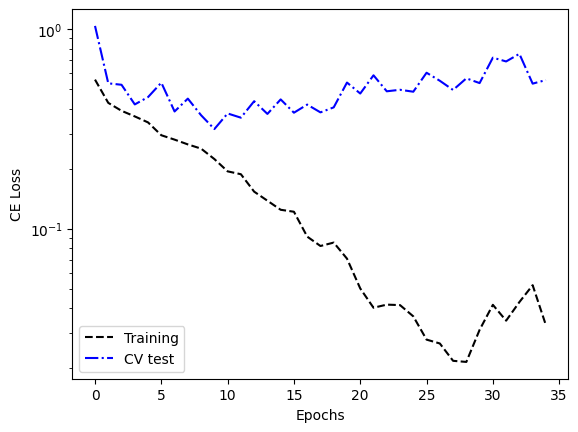

time: 450 ms (started: 2023-05-17 15:13:57 +00:00)


In [29]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist)

    "I will probably increase the number of filters": The filters in convolutional layers learn to identify patterns in the data, such as edges, shapes, or even more complex patterns when deeper in the network. By increasing the number of filters, you give the model more "capacity" to learn a larger number of patterns. However, it will also increase the computational cost and could lead to overfitting if your dataset is not large enough.

    "After flattening, he said he needs to do a regression task there": This statement might seem confusing in a classification context. However, it's possible your professor was referring to the output of the last layer before the classification layer. At this stage, the network might be generating high-level, dense representations of the input data, which could be used for different tasks - not only classification but also regression.

    "Maybe I can do dimensionality reduction with a dense layer, then pass it to the binary classification task.": This means that your professor is considering adding a dense layer with fewer nodes than the flattened layer. This would serve to reduce the dimensionality of the model's internal representation of the data. This approach can help in simplifying the model and focusing on the most important features, which can help with performance and generalization.

    "The DR is extremely costly, we have around 6 million parameters here.": DR stands for Dimensionality Reduction, which is a computationally expensive process. In the context of a neural network with 6 million parameters, dimensionality reduction might be necessary to prevent overfitting and reduce computational requirements, but it will indeed require additional processing.

    "If you applied the MLP at the beginning it will be much more complex.": MLP stands for Multi-Layer Perceptron, a type of fully connected neural network. If you apply an MLP to the raw pixel data (instead of to the output of the convolutional layers), it would be dealing with much higher-dimensional data and would thus be more complex and computationally expensive. Plus, an MLP does not consider the spatial relationships between pixels, which are very important in image data. That's why convolutional layers are used first in this type of model.

In [30]:
# Defining our function to see the evolution of error:
def plot_learning_curves_2(history):
  #We will omit the first 0 points for a better visualization:
  plt.plot(history['epoch'][0:],history['accuracy'][0:], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'][0:],history['val_accuracy'][0:], "b-.", linewidth=1.5, label="CV test")
  plt.legend()
# plt.ylim(1,100)
# plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("Accuracy")

time: 680 µs (started: 2023-05-17 15:13:58 +00:00)


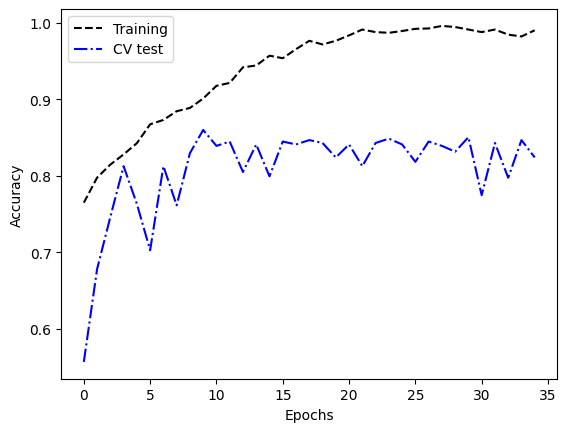

time: 240 ms (started: 2023-05-17 15:13:58 +00:00)


In [31]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves_2(hist)

## Evaluation metrics

It is clearly seen that we are overfitting with the current model. Lets see our performance matrices. We will use confusion matrix, PR curve and ROC curve.

We will start with making predictions and then data conversion to be able to apply evaluation tools.

In [32]:
y_test_predictions = model_best.predict(X_test)


21/21 [==============================] - 1s 41ms/step
time: 2.65 s (started: 2023-05-17 15:13:58 +00:00)


In [33]:
#y_test_classes = model_best.predict_classes(X_test, verbose=0)
'''
tensorflow\python\keras\engine\sequential.py:455: UserWarning: model.predict_classes() is deprecated and will be removed after 2021-01-01. 
Please use instead:* np.argmax(model.predict(x), axis=-1), if your model does multi-class classification 
(e.g. if it uses a softmax last-layer activation).* (model.predict(x) > 0.5).astype("int32"), 
if your model does binary classification (e.g. if it uses a sigmoid last-layer activation).
'''
y_test_classes  = (y_test_predictions > 0.5).astype("int32")

time: 1.45 ms (started: 2023-05-17 15:14:01 +00:00)


In [34]:
# seeing an example output from sigmoid layer:
print(y_test_predictions[66], y_test_classes[66])

[0.7374129] [1]
time: 4.98 ms (started: 2023-05-17 15:14:01 +00:00)


`scikit-learn` metrics expect a 1D array of actual and predicted values for comparison so we must reduce the array dimensions.

In [35]:
y_test_predictions = y_test_predictions[:, 0]
y_test_classes = y_test_classes[:]

time: 582 µs (started: 2023-05-17 15:14:01 +00:00)


### Confusion matrix

In [36]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)
conf_matrix = confusion_matrix(y_test,y_test_classes)
conf_matrix

array([[299,  61],
       [ 30, 270]])

time: 12 ms (started: 2023-05-17 15:14:01 +00:00)


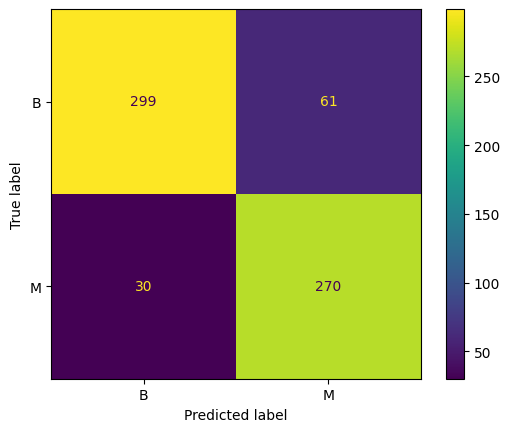

time: 250 ms (started: 2023-05-17 15:14:01 +00:00)


In [37]:
CM = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=('B', 'M'))
CM.plot()

### Various scores

In [38]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test,y_test_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test,y_test_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test,y_test_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test,y_test_classes)
print('F1 score: %f' % f1)
kappa_score = cohen_kappa_score(y_test,y_test_classes)
print('Cohens kappa: %f' % kappa_score)
# ROC AUC
auc_score = roc_auc_score(y_test, y_test_predictions)
print('ROC AUC: %f' % auc_score)

Accuracy: 0.862121
Precision: 0.815710
Recall: 0.900000
F1 score: 0.855784
Cohens kappa: 0.724318
ROC AUC: 0.935389
time: 27.2 ms (started: 2023-05-17 15:14:01 +00:00)


### PR Curve

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.92')

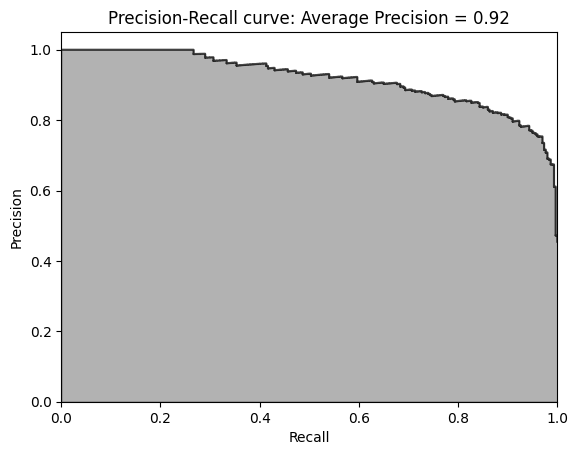

time: 261 ms (started: 2023-05-17 15:14:01 +00:00)


In [39]:
precision, recall, thresholds = precision_recall_curve(y_test,y_test_predictions)
average_precision = average_precision_score(y_test,y_test_predictions)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

### ROC curve


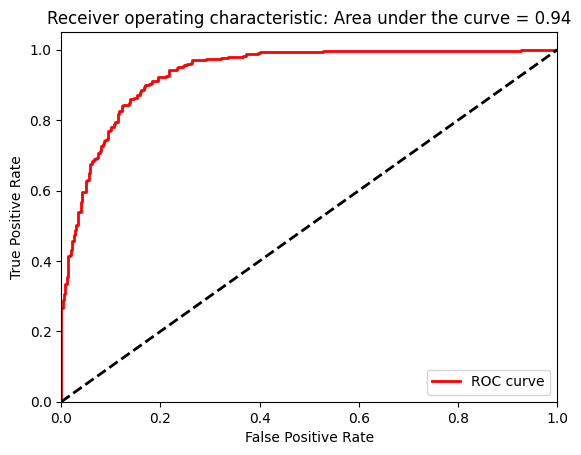

time: 229 ms (started: 2023-05-17 15:14:01 +00:00)


In [40]:
fpr, tpr, thresholds = roc_curve(y_test,y_test_predictions)
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

    When a model has many parameters (like 6 million in this case), it is considered highly complex. A complex model can capture a wide variety of patterns in the data. However, if the amount of training data is relatively small (like a few thousand examples), the model is likely to overfit. Overfitting means the model is so well adapted to the training data that it performs poorly on new, unseen data.

    Overfitting is a common problem in machine learning, and it happens when the model learns the noise and specific details in the training data to the extent that it negatively impacts the performance of the model on new data. The problem here is not with the model but with the fact that the model's capacity is much higher than the complexity of the task.

    To mitigate this issue, your professor suggested two strategies:

    Simplify the model: This could mean reducing the number of layers or the number of neurons in each layer, which would reduce the number of parameters. A simpler model would be less likely to overfit to the training data.

    Apply regularization: Regularization techniques can also help prevent overfitting. They work by adding a penalty to the loss function that increases with the complexity of the model. For example, L1 and L2 regularization add a term to the loss function that is proportional to the absolute value or the square of the model parameters, respectively.

    Get more data: Finally, collecting more training data can help improve the model's ability to generalize. With more data, the model can learn more varied patterns and will be better able to apply what it has learned to new data.

# Looking for alternatives

Our score so far is compatable to an expert already but we would like to further improve our score. We will eplore two options here together and you will be given exercises to further play with the model. The options we will explore are:

+ pooling layers & 
+ data agumentation.

## Impact of Pooling

In the basic architecture, we introduce MaxPooling to downsample the input image, with the objective of reduce the computational load, the memory usage, and the number of parameters.By doing so, it also adds a bit of regularization into the picture.

Since we are overfitting, I will increase the pooling size and a bit of further regularization.

### Model architecture

In [25]:
def build_model_CNN_2():
  # input array shape for the network:
  input_shape = X_train.shape[1],X_train.shape[2],X_train.shape[3]
  #Here we will use Sequential API like we did in MLP
  model = models.Sequential([
  # Now we will introduce the layers. We will start with the convolution layer:
  #https://keras.io/api/layers/convolution_layers/
  #https://keras.io/api/layers/convolution_layers/convolution2d/
  Conv2D(64,(3,3),(1,1),padding='same',activation="relu",kernel_initializer="he_uniform",kernel_regularizer=regularizers.l1(0.001),input_shape=input_shape),
  #Adding the pooling layer:
  #https://keras.io/api/layers/pooling_layers/
  #https://keras.io/api/layers/pooling_layers/max_pooling2d/
  MaxPooling2D((3,3),padding='same'),
  BatchNormalization(),
  #Dropout(0.2),
  #
  #Second conv. layer:
  Conv2D(64,(3,3),(1,1),padding='same',activation="relu",kernel_initializer="he_uniform",kernel_regularizer=regularizers.l1(0.001)),
  MaxPooling2D((3,3),padding='same'),
  BatchNormalization(),
  #Dropout(0.2),
  #
  #Third conv. layer:
  Conv2D(64,(3,3),(1,1),padding='same',activation="relu",kernel_initializer="he_uniform",kernel_regularizer=regularizers.l1(0.001)),
  MaxPooling2D((3,3),padding='same'),
  BatchNormalization(),
  #Dropout(0.2),
  #
  #Connecting to dense layer:
  Flatten(),
  #Ready to link MLP
  Dense(128,activation="relu",kernel_initializer="he_uniform",kernel_regularizer=regularizers.l1(0.001)),
  BatchNormalization(),
  Dropout(0.2),
  Dense(1,activation="sigmoid")
  ])
  model.compile(optimizer='Adam',loss = "binary_crossentropy", metrics=["accuracy"])
  return model


time: 1.14 ms (started: 2023-05-17 16:22:13 +00:00)


In [26]:
#Looking at the graph:
build_model_CNN_2().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 75, 75, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                        

### Model training

Our model is ready as a graph object. Now we are ready to train it with our dataset. As usual, we will create a checkpoint to save better results and use early stopping to limit the training period, as well as over fitting.

In [24]:
#We will first create the object to feed fit() method:
myCheckpoint_2= keras.callbacks.ModelCheckpoint("my_best_model_2.h5", save_best_only=True)

time: 560 µs (started: 2023-05-17 16:08:46 +00:00)


In [25]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
myEarly_stopping_2 = keras.callbacks.EarlyStopping(patience=25,restore_best_weights=True)

time: 375 µs (started: 2023-05-17 16:08:46 +00:00)


In [26]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 100
batch_size = 32

time: 370 µs (started: 2023-05-17 16:08:46 +00:00)


In [27]:
# Model Training:
#-----------------------------------------------------------------------------
#Building the Keras models:
model_CNN_2 = build_model_CNN_2()

#Training step: Trains the model in silent mode (verbose = 0)
history_2= model_CNN_2.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.2, 
                                callbacks=[myCheckpoint_2,myEarly_stopping_2])#, verbose=0)
#Calling back the best model:
model_best_2= keras.models.load_model("my_best_model_2.h5")


Epoch 1/100
66/66 [==============================] - 20s 90ms/step - loss: 11.3218 - accuracy: 0.7824 - val_loss: 7.6482 - val_accuracy: 0.5606
Epoch 2/100
66/66 [==============================] - 4s 59ms/step - loss: 5.7136 - accuracy: 0.7966 - val_loss: 5.1026 - val_accuracy: 0.5568
Epoch 3/100
66/66 [==============================] - 4s 56ms/step - loss: 4.1518 - accuracy: 0.8103 - val_loss: 3.8577 - val_accuracy: 0.6458
Epoch 4/100
66/66 [==============================] - 4s 57ms/step - loss: 3.3846 - accuracy: 0.8084 - val_loss: 3.3197 - val_accuracy: 0.7595
Epoch 5/100
66/66 [==============================] - 4s 64ms/step - loss: 2.9393 - accuracy: 0.8160 - val_loss: 2.9878 - val_accuracy: 0.5568
Epoch 6/100
66/66 [==============================] - 4s 57ms/step - loss: 2.3006 - accuracy: 0.8279 - val_loss: 2.1339 - val_accuracy: 0.8333
Epoch 7/100
66/66 [==============================] - 4s 61ms/step - loss: 1.8892 - accuracy: 0.8393 - val_loss: 1.9465 - val_accuracy: 0.7405
Epoc

In [28]:
#Lets look into the history recorded:
hist_2 = pd.DataFrame(history_2.history)
hist_2.sample(3)

,loss,accuracy,val_loss,val_accuracy
7,1.852333,0.825510,1.785523,0.734848
63,0.528610,0.955429,0.897364,0.814394
24,0.888937,0.860597,0.946599,0.844697


time: 53.2 ms (started: 2023-05-17 16:16:13 +00:00)


In [29]:
#Adding epoch column:
hist_2['epoch'] = history_2.epoch
# As you can see, we have the losses as well as mae for both training and CV data:
hist_2.sample(3)

,loss,accuracy,val_loss,val_accuracy,epoch
29,0.934281,0.879090,1.044876,0.831439,29
65,0.551120,0.943575,0.981174,0.784091,65
82,0.523461,0.951162,1.230674,0.753788,82


time: 10.6 ms (started: 2023-05-17 16:16:13 +00:00)


In [30]:
# Defining our function to see the evolution of error:
def plot_learning_curves(history):
  #We will omit the first 0 points for a better visualization:
  plt.plot(history['epoch'][0:],history['loss'][0:], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'][0:],history['val_loss'][0:], "b-.", linewidth=1.5, label="CV test")
  plt.legend()
 # plt.ylim(1,100)
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("CE Loss")

time: 724 µs (started: 2023-05-17 16:16:13 +00:00)


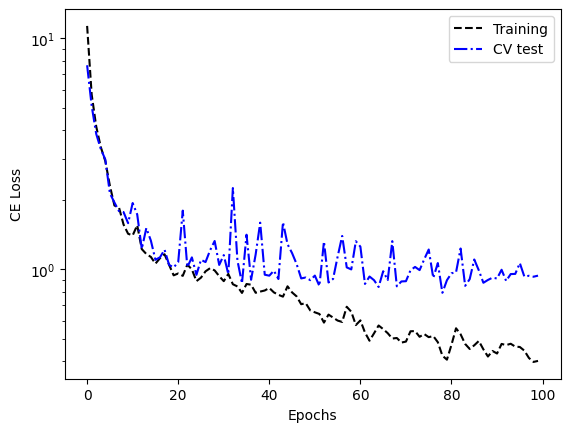

time: 377 ms (started: 2023-05-17 16:16:13 +00:00)


In [31]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist_2)

In [32]:
# Defining our function to see the evolution of error:
def plot_learning_curves_2(history):
  #We will omit the first 0 points for a better visualization:
  plt.plot(history['epoch'][0:],history['accuracy'][0:], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'][0:],history['val_accuracy'][0:], "b-.", linewidth=1.5, label="CV test")
  plt.legend()
# plt.ylim(1,100)
# plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("Accuracy")

time: 693 µs (started: 2023-05-17 16:16:14 +00:00)


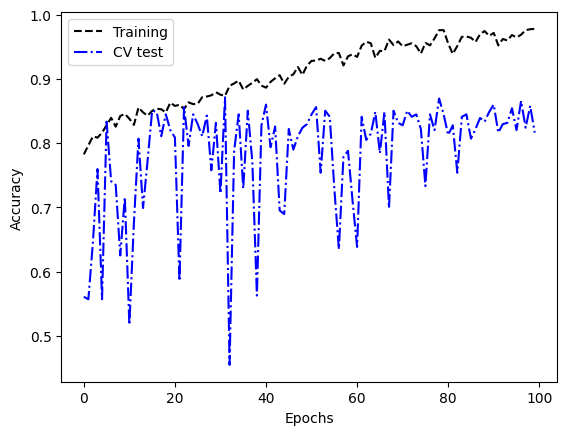

time: 243 ms (started: 2023-05-17 16:16:14 +00:00)


In [33]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves_2(hist_2)

### Evaluation metrics

In [34]:
y_test_predictions_2 = model_best_2.predict(X_test)
#y_test_classes_2 = model_best_2.predict_classes(X_test, verbose=0)
y_test_classes_2  = (y_test_predictions_2 > 0.5).astype("int32")

21/21 [==============================] - 1s 32ms/step
time: 2.04 s (started: 2023-05-17 16:16:14 +00:00)


In [35]:
# seeing an example output from sigmoid layer:
print(y_test_predictions_2[0], y_test_classes_2[0])

[0.8902647] [1]
time: 3.79 ms (started: 2023-05-17 16:16:16 +00:00)


`scikit-learn` metrics expect a 1D array of actual and predicted values for comparison so we must reduce the array dimensions.

In [36]:
y_test_predictions_2 = y_test_predictions_2[:, 0]
y_test_classes_2 = y_test_classes_2[:, 0]

time: 331 µs (started: 2023-05-17 16:16:16 +00:00)


#### Confusion matrix

In [37]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)
conf_matrix = confusion_matrix(y_test,y_test_classes_2)
conf_matrix

array([[314,  46],
       [ 47, 253]])

time: 13 ms (started: 2023-05-17 16:16:16 +00:00)


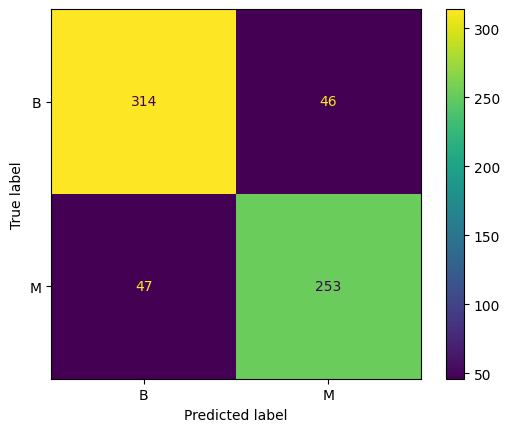

time: 223 ms (started: 2023-05-17 16:16:16 +00:00)


In [38]:
CM = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=('B', 'M'))
CM.plot()

#### Various scores

In [39]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test,y_test_classes_2)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test,y_test_classes_2)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test,y_test_classes_2)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test,y_test_classes_2)
print('F1 score: %f' % f1)
kappa_score = cohen_kappa_score(y_test,y_test_classes_2)
print('Cohens kappa: %f' % kappa_score)
# ROC AUC
auc_score = roc_auc_score(y_test, y_test_predictions_2)
print('ROC AUC: %f' % auc_score)

Accuracy: 0.859091
Precision: 0.846154
Recall: 0.843333
F1 score: 0.844741
Cohens kappa: 0.715754
ROC AUC: 0.925519
time: 26.5 ms (started: 2023-05-17 16:16:16 +00:00)


#### PR Curve

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.90')

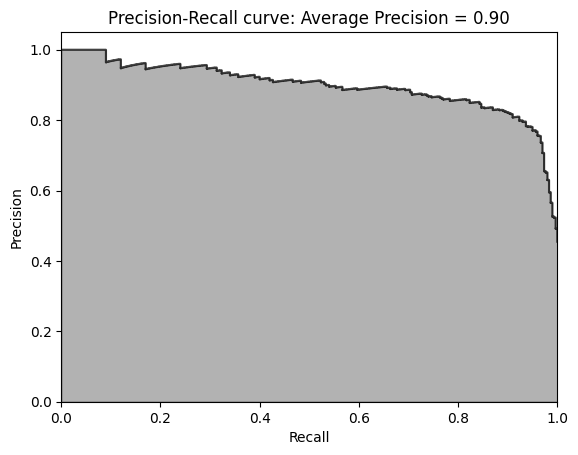

time: 238 ms (started: 2023-05-17 16:16:16 +00:00)


In [40]:
precision, recall, thresholds = precision_recall_curve(y_test,y_test_predictions_2)
average_precision = average_precision_score(y_test,y_test_predictions_2)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

#### ROC curve


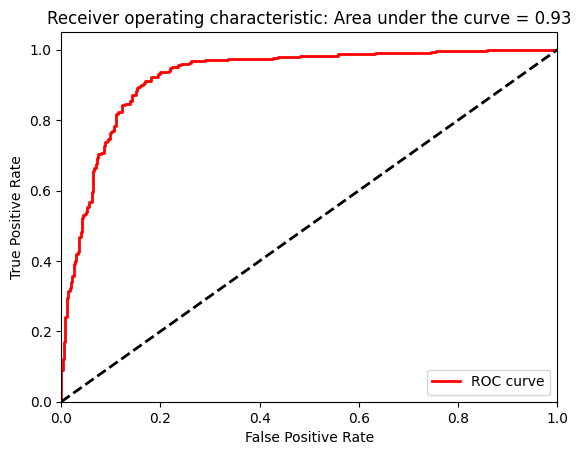

time: 194 ms (started: 2023-05-17 16:16:17 +00:00)


In [41]:
fpr, tpr, thresholds = roc_curve(y_test,y_test_predictions_2)
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# Increasing the volume of the data in image processing

It looks like we have hit the wall. We may push the predictive accuracy to a bit higher levels with fine tuning the model but there may be an alternative option as well. 

Image data augmentation is a useful method that can be used to artificially expand the size of a training dataset by creating slighlty modified versions of the original images in the dataset. Good news is we do not have to code it from the scratch; TF (Keras) already has a solution: `ImageDataGenerator` class:

https://keras.io/api/preprocessing/image/

```
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    dtype=None,
)

```

The options include, but not limited to

* `width_shift_range` and `height_shift_range`:  shifts the image,
* `horizontal_flip` and `vertical_flip` :  flips images
* `rotation_range` : rotates image
* `brightness_range` : setting brightness 
* `zoom_range` : image zooming

see also:

https://www.tensorflow.org/tutorials/images/data_augmentation

https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844

https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/





    Image augmentation is a strategy that enables practitioners to significantly increase the diversity of images available for training models, without actually collecting new data. This is accomplished by applying a series of random transformations to the original images, such as rotation, scaling, shifting, flipping, etc. The objective is to simulate the variety of perspectives, angles, and conditions that the model may encounter in the real world.

    For example, let's say you're training a model to recognize cats, and you have a photo of a cat sitting upright. With augmentation, you could generate more images of the same cat but from different angles, slightly zoomed in or out, mirrored, etc. This can help your model generalize better, as it will see more variations of the same object.

    Now, coming to the part where your professor says that at every epoch, the model sees a new dataset, this is because these random transformations are typically applied just in time, during training. This means for each image during each epoch (one pass over the entire dataset), a new random transformation is applied. So, in effect, the model never really sees the exact same image twice. This can help improve the model's ability to generalize, as it is being continually challenged during training with "new" images that are still representative of the original data.

    This technique is particularly useful when the amount of training data is limited, as it helps prevent overfitting by providing a more diverse set of training examples.

## Implementation

In [27]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range=20, 
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2,
        horizontal_flip=True,  
        vertical_flip=True, 
        preprocessing_function=None,
        validation_split=0.2)

datagen.fit(X_train)

time: 1.46 s (started: 2023-05-17 16:22:28 +00:00)


In [28]:
#We will first create the object to feed fit() method:
myCheckpoint_3= keras.callbacks.ModelCheckpoint("my_best_model_3.h5", save_best_only=True)

time: 633 µs (started: 2023-05-17 16:22:30 +00:00)


In [29]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
#myEarly_stopping_3 = keras.callbacks.EarlyStopping(patience=25,restore_best_weights=True)

time: 316 µs (started: 2023-05-17 16:22:30 +00:00)


    In training a neural network, learning rate is one of the most important hyperparameters. The learning rate defines the step size during gradient descent. A large learning rate allows the model to learn faster, at the cost of possibly overshooting the minimum point due to large step size. Conversely, a small learning rate could lead to slower convergence, but it allows the model to find the minimum more accurately.

    In the code you posted, ReduceLROnPlateau is a callback function in Keras that reduces the learning rate when a metric has stopped improving. Here is a breakdown of the arguments:

    - monitor='val_accuracy': This argument specifies the performance measure to check if the model's performance has improved or not. In this case, the callback will monitor the validation accuracy of the model.

    - factor=0.618: If no improvement is seen in the 'val_accuracy' for a 'patience' number of epochs, the learning rate will be reduced by this factor. In this case, the learning rate will be multiplied by 0.618 (approximately the golden ratio, often used in optimization problems).

    - patience=3: Number of epochs with no improvement after which learning rate will be reduced. So if the validation accuracy does not improve for 3 epochs, the learning rate will be reduced.

    - min_lr=0.00001: Lower bound on the learning rate. The learning rate will never go below this value even after many reductions.

    This technique is used to fine-tune the model. When the model stops improving with the current learning rate, it is often beneficial to reduce the learning rate so the model can continue to learn and potentially reach a better minimum.

In [30]:
# Alternative checkpoint - if accuracy doesn't improve after 3 epoch then reduce lr by factor 0.5 
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.618,patience=3, min_lr=0.00001)

time: 636 µs (started: 2023-05-17 16:22:30 +00:00)


In [31]:
model_CNN = build_model_CNN_2()

time: 136 ms (started: 2023-05-17 16:22:30 +00:00)


In [32]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 100
batch_size = 32

time: 526 µs (started: 2023-05-17 16:22:30 +00:00)


In [33]:
# Training the model:
# here we will fit the model on batches with real-time data augmentation;
history_3 = model_CNN.fit(datagen.flow(X_train, y_train, batch_size=batch_size,subset='training'),
                          epochs=num_epochs,
                          #validation_split=0.2,
                          validation_data=datagen.flow(X_train, y_train, batch_size=batch_size, subset='validation'), 
                          callbacks=[myCheckpoint_3,reduce_lr])#, verbose=0))

#Calling back the best model:
model_best_3= keras.models.load_model("my_best_model_3.h5")

Epoch 1/100
66/66 [==============================] - 52s 553ms/step - loss: 11.5446 - accuracy: 0.7706 - val_loss: 7.9706 - val_accuracy: 0.4820 - lr: 0.0010
Epoch 2/100
66/66 [==============================] - 37s 571ms/step - loss: 5.8888 - accuracy: 0.8033 - val_loss: 5.2445 - val_accuracy: 0.5636 - lr: 0.0010
Epoch 3/100
66/66 [==============================] - 34s 515ms/step - loss: 4.1686 - accuracy: 0.7957 - val_loss: 3.8063 - val_accuracy: 0.6471 - lr: 0.0010
Epoch 4/100
66/66 [==============================] - 33s 496ms/step - loss: 3.3156 - accuracy: 0.7825 - val_loss: 3.0734 - val_accuracy: 0.7533 - lr: 0.0010
Epoch 5/100
66/66 [==============================] - 37s 567ms/step - loss: 2.7549 - accuracy: 0.8000 - val_loss: 2.6923 - val_accuracy: 0.5939 - lr: 0.0010
Epoch 6/100
66/66 [==============================] - 33s 494ms/step - loss: 2.3668 - accuracy: 0.7782 - val_loss: 2.1901 - val_accuracy: 0.7097 - lr: 0.0010
Epoch 7/100
66/66 [==============================] - 34s 

In [34]:
#Lets look into the history recorded:
hist_3 = pd.DataFrame(history_3.history)
hist_3.head(3)

,loss,accuracy,val_loss,val_accuracy,lr
0,11.544590,0.770616,7.970596,0.481973,0.001
1,5.888826,0.803318,5.244464,0.563567,0.001
2,4.168585,0.795735,3.806324,0.647059,0.001


time: 47.3 ms (started: 2023-05-17 17:20:44 +00:00)


In [35]:
#Lets look into the history recorded:
hist_3 = pd.DataFrame(history_3.history)
hist_3.sample(3)

,loss,accuracy,val_loss,val_accuracy,lr
24,0.785448,0.844550,0.873227,0.789374,0.000146
29,0.740867,0.852133,0.707202,0.850095,0.000146
79,0.545041,0.879621,0.546075,0.886148,0.000010


time: 21.4 ms (started: 2023-05-17 17:20:44 +00:00)


In [36]:
#Adding epoch column:
hist_3['epoch'] = history_3.epoch
# As you can see, we have the losses as well as mae for both training and CV data:
hist_3.sample(3)

,loss,accuracy,val_loss,val_accuracy,lr,epoch
18,0.994124,0.819905,1.111504,0.821632,0.000382,18
51,0.566837,0.887678,0.618524,0.850095,0.000013,51
53,0.561063,0.879147,0.549702,0.876660,0.000010,53


time: 13.3 ms (started: 2023-05-17 17:20:44 +00:00)


In [37]:
# Defining our function to see the evolution of error:
def plot_learning_curves(history):
  #We will omit the first 0 points for a better visualization:
  plt.plot(history['epoch'][0:],history['loss'][0:], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'][0:],history['val_loss'][0:], "b-.", linewidth=1.5, label="CV test")
  plt.legend()
 # plt.ylim(1,100)
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("CE Loss")

time: 645 µs (started: 2023-05-17 17:20:44 +00:00)


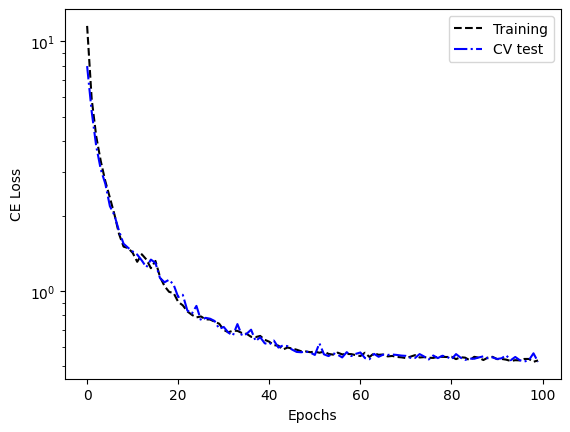

time: 412 ms (started: 2023-05-17 17:20:44 +00:00)


In [38]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist_3)

In [39]:
# Defining our function to see the evolution of error:
def plot_learning_curves_2(history):
  #We will omit the first 0 points for a better visualization:
  plt.plot(history['epoch'][0:],history['accuracy'][0:], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'][0:],history['val_accuracy'][0:], "b-.", linewidth=1.5, label="CV test")
  plt.legend()
  plt.ylim(0.5,1)
# plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("Accuracy")

time: 1.01 ms (started: 2023-05-17 17:20:45 +00:00)


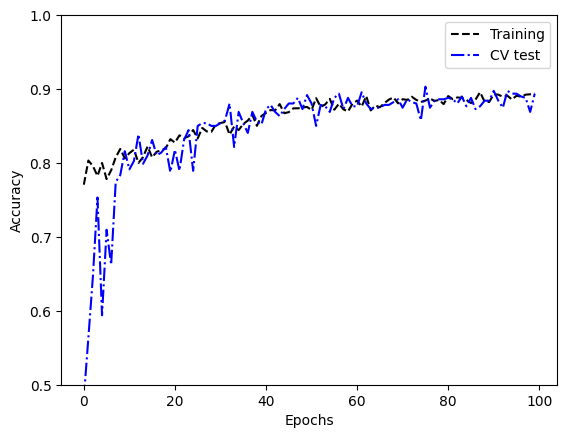

time: 232 ms (started: 2023-05-17 17:20:45 +00:00)


In [40]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves_2(hist_3)

### Evaluation metrics

In [41]:
y_test_predictions_3 = model_best_3.predict(X_test)
#y_test_classes_3 = model_best_3.predict_classes(X_test, verbose=0)
y_test_classes_3  = (y_test_predictions_3 > 0.5).astype("int32")


21/21 [==============================] - 1s 32ms/step
time: 2.86 s (started: 2023-05-17 17:20:45 +00:00)


In [42]:
# seeing an example output from sigmoid layer:
print(y_test_predictions_3[0], y_test_classes_3[0])

[0.00126998] [0]
time: 4.13 ms (started: 2023-05-17 17:20:48 +00:00)


`scikit-learn` metrics expect a 1D array of actual and predicted values for comparison so we must reduce the array dimensions.

In [43]:
y_test_predictions_3 = y_test_predictions_3[:, 0]
y_test_classes_3 = y_test_classes_3[:, 0]

time: 333 µs (started: 2023-05-17 17:20:48 +00:00)


#### Confusion matrix

In [44]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)
conf_matrix = confusion_matrix(y_test,y_test_classes_3)
conf_matrix

array([[321,  39],
       [ 48, 252]])

time: 16.5 ms (started: 2023-05-17 17:20:48 +00:00)


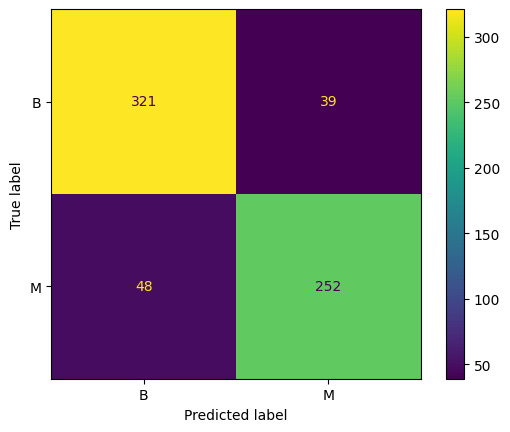

time: 277 ms (started: 2023-05-17 17:20:48 +00:00)


In [45]:
CM = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=('B', 'M'))
CM.plot()

#### Various scores

In [46]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test,y_test_classes_3)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test,y_test_classes_3)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test,y_test_classes_3)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test,y_test_classes_3)
print('F1 score: %f' % f1)
kappa_score = cohen_kappa_score(y_test,y_test_classes_3)
print('Cohens kappa: %f' % kappa_score)
# ROC AUC
auc_score = roc_auc_score(y_test, y_test_predictions_3)
print('ROC AUC: %f' % auc_score)

Accuracy: 0.868182
Precision: 0.865979
Recall: 0.840000
F1 score: 0.852792
Cohens kappa: 0.733500
ROC AUC: 0.952574
time: 21.3 ms (started: 2023-05-17 17:20:48 +00:00)


#### PR Curve

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.94')

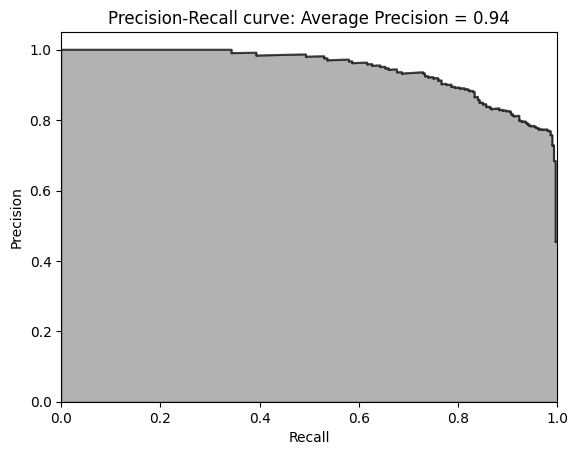

time: 251 ms (started: 2023-05-17 17:20:48 +00:00)


In [47]:
precision, recall, thresholds = precision_recall_curve(y_test,y_test_predictions_3)
average_precision = average_precision_score(y_test,y_test_predictions_3)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

#### ROC curve


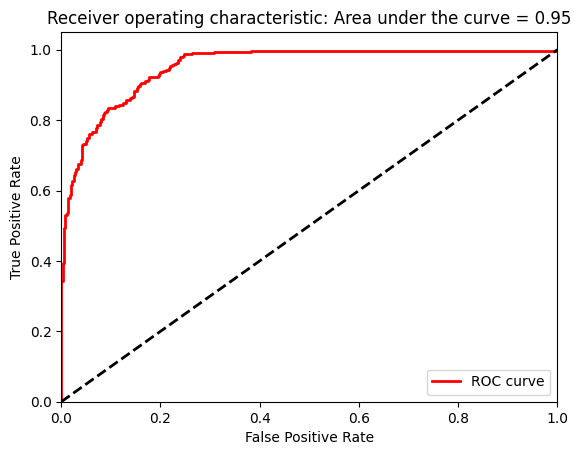

time: 208 ms (started: 2023-05-17 17:20:49 +00:00)


In [48]:
fpr, tpr, thresholds = roc_curve(y_test,y_test_predictions_3)
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# Exercise options

+ Play with learning rate and regularization options.

+ play with the architecture.

+ try different number of filters.

+ explore the impact of pooling and maxpooling. 

# Reading materials and further references


## Basic tutorials and resources on CNN

+ [Basic CNN implementation](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/)




## Previous challenges and calls for the task:

+ [ISIC 2018: Skin Lesion Analysis Towards Melanoma Detection](https://challenge2018.isic-archive.com/)

+  [HAM10000 dataset](https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000)

+ [SIIM-ISIC Melanoma Classification](https://www.kaggle.com/c/siim-isic-melanoma-classification/data)







## Case study: Skin cancer classification

+ [What is melanoma?](https://www.youtube.com/watch?v=mkYBxfKDyv0)

+ [Skin cancer classification with deep learning](https://cs.stanford.edu/people/esteva/nature/)

+ [Skin Cancer Classification Using Convolutional Neural Networks: Systematic Review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6231861/)

+ [DePicT Melanoma Deep-CLASS](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-020-3351-y)
